# LeNet 5

En este Notebook se va a implementar la red convolucional **LeNet 5** en el dataset de nubes creado anteriormente.

In [143]:
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from print_confusion_matrix import print_confusion_matrix

import numpy as np
import pandas as pd
import sklearn.utils
import matplotlib.pyplot as plt

%matplotlib inline

## Formatear el dataset
Primero cargamos los datos desde el disco

In [108]:
cloud_pd = joblib.load('data/clouds.pkl')
cloud_pd = sklearn.utils.shuffle(cloud_pd)

Se cuentan los datos que tenemos por cada clase para ver la cantidad que hay de cada uno.

In [109]:
cloud_pd.groupby(by='cloud_type').cloud_type.count()

cloud_type
altocumulos        1729
altostratos        1727
cirros              660
estratocumulos     1743
sky               14109
Name: cloud_type, dtype: int64

Hay pocos datos de cirros, por lo que sería necesario aumentar el numero de datos de esta clase creando imagenes sinteticas de las disponibles. Ademas hay un gran numero de muestras de la clase **sky** con respecto a las demas.

En la siguiente celda se borra esta clase, pues no tiene mucho sentido introducirla en la clasificación. Pues es facilmente diferenciable con el preprocesado que se hizo con los patches en el notebook anterior.

In [110]:
cloud_pd = cloud_pd[cloud_pd.cloud_type != 'sky']

Crear una lookup_table con las etiquetas de las nubes y generar sus indices para el dataset.

In [111]:
cloud_lookup_table, cloud_pd.cloud_type = np.unique(cloud_pd.cloud_type.values,
                                                    return_inverse=True)

print('- Clouds Lookup-table: ', cloud_lookup_table)

- Clouds Lookup-table:  ['altocumulos' 'altostratos' 'cirros' 'estratocumulos']


Dividimos el dataset en sets de train y test.

In [120]:
batchsize = 32
nData = cloud_pd.shape[0]
nData_training = int(nData * 2/3)

# Batches number for training
batches = int(nData_training / batchsize)
nData_training = batches * batchsize
nData_testing = nData - nData_training

print('- Number Data training: {}'.format(nData_training))
print('- Number batches: {}'.format(batches))
print('- Number Data testing: {}'.format(nData_testing))

- Number Data training: 3904
- Number batches: 122
- Number Data testing: 1955


In [122]:
cloud_x = cloud_pd.iloc[:nData_training, 2:]
cloud_y = cloud_pd.iloc[:nData_training, 0]

cloud_test_x = cloud_pd.iloc[nData_training:, 2:]
cloud_test_y = cloud_pd.iloc[nData_training:, 0]

Importar paquetes necesarios de **pyTorch** y convertir los datos a tensores.

In [123]:
from torch.autograd import Variable

import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F

In [124]:
# Training
cloud_x = cloud_x.values.reshape((batches, batchsize, 
                                  32, 32, 3)).astype('uint8')
cloud_x = np.transpose(cloud_x, axes=(0, 1, 4, 2, 3))

cloud_y = cloud_y.values.reshape((batches, batchsize))

# Testing
cloud_test_x = cloud_test_x.values.reshape((cloud_test_x.shape[0],
                                            32, 32, 3)).astype('uint8')
cloud_test_x = np.transpose(cloud_test_x, axes=(0, 3, 1, 2))

cloud_test_y = cloud_test_y.values

# Convert to tensors
cloud_x = Variable(torch.Tensor(cloud_x).contiguous().cuda())
cloud_y = Variable(torch.LongTensor(cloud_y).contiguous().cuda())
cloud_test_x = Variable(torch.Tensor(cloud_test_x).contiguous().cuda())

print('- Cloud_x {}'.format(cloud_x.shape))
print('- Cloud_y {}'.format(cloud_y.shape))
print('- Cloud_test_x {}'.format(cloud_test_x.shape))
print('- Cloud_test_y {}'.format(cloud_test_y.shape))

- Cloud_x torch.Size([122, 32, 3, 32, 32])
- Cloud_y torch.Size([122, 32])
- Cloud_test_x torch.Size([1955, 3, 32, 32])
- Cloud_test_y (1955,)


En este paso se normaliza el dataset

In [125]:
cloud_x = F.normalize(cloud_x, dim=2)
cloud_test_x = F.normalize(cloud_test_x, dim=1)

## Definir la red neuronal

A partir de este punto, se va a definir la arquitecture de **LeNet-5**. Tal y como se muestra en la imagen de abajo, la red esta formada por 2 capas de convolución con un filtro de tamaño (5x5) seguidas de maxpooling (2,2) y 3 capas ocultas fully connected al final.

![Architecture of LeNet-5](https://www.researchgate.net/profile/Vladimir_Golovko3/publication/313808170/figure/fig3/AS:552880910618630@1508828489678/Architecture-of-LeNet-5.ppm)

In [154]:
class LeNet(nn.Module):
    
    def __init__(self):
        super(LeNet, self).__init__()
        # First convolutional layer, 6 channels, kernel 5x5
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        
        # Second convolutional layer, 16 channels, kernel 5x5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        
        # Dropout 0.5
        self.drop = nn.Dropout(0.3)
        
        # Fully connected
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(cloud_lookup_table))
        
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        
    def forward(self, x):
        b_size = x.size(0)

        # Max pooling (2,2)
        x = F.max_pool2d(F.relu(self.drop(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.drop(self.conv2(x))), (2, 2))
        x = x.view(b_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x)
        
net = LeNet().cuda()
print(net)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (drop): Dropout(p=0.3)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)


In [162]:
class LeNet(nn.Module):
    
    def __init__(self):
        super(LeNet, self).__init__()
        # First convolutional layer, 6 channels, kernel 5x5
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        
        # Second convolutional layer, 16 channels, kernel 5x5
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        
        # Dropout 0.5
        self.drop = nn.Dropout(0.3)
        
        # Fully connected
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, len(cloud_lookup_table))
        
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        b_size = x.size(0)

        # Max pooling (2,2)
        x = F.max_pool2d(F.relu(self.drop(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.drop(self.conv2(x))), (2, 2))
        x = x.view(b_size, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x)
        
net = LeNet().cuda()
print(net)

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (drop): Dropout(p=0.3)
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=4, bias=True)
)


In [163]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.03)
loss_function = F.nll_loss
success_history = list()

import time

start = time.time()

for epoch in range(500):
    net.train()
    
    # Training
    for idx in range(cloud_x.shape[0]):
        batch = cloud_x[idx]
        target = cloud_y[idx]
        optimizer.zero_grad() # set to zero gradient buffers
        output = net.forward(batch)
        loss = loss_function(output, target)
        loss.backward() # compute gradients
        optimizer.step() # do the update
        
    # Testing  
    net.eval()
    
    output_test = np.argmax(net(cloud_test_x).data.cpu().numpy(), axis=1)
    success = (cloud_test_y == output_test)
    success_history.append(success.sum() / success.shape[0])
    
    print('[Epoch {}] Train loss: {} Test accuracy: {}'.format(epoch, loss, success_history[epoch]))
    
end = time.time()
print('\n- Time: ', end - start)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch 0] Train loss: 1.3384778499603271 Test accuracy: 0.30025575447570335
[Epoch 1] Train loss: 1.3286011219024658 Test accuracy: 0.30127877237851663
[Epoch 2] Train loss: 1.3294490575790405 Test accuracy: 0.30127877237851663
[Epoch 3] Train loss: 1.3304206132888794 Test accuracy: 0.30076726342710997
[Epoch 4] Train loss: 1.3260422945022583 Test accuracy: 0.3069053708439898
[Epoch 5] Train loss: 1.3235806226730347 Test accuracy: 0.30434782608695654
[Epoch 6] Train loss: 1.3321428298950195 Test accuracy: 0.3053708439897698
[Epoch 7] Train loss: 1.3270095586776733 Test accuracy: 0.3053708439897698
[Epoch 8] Train loss: 1.3213058710098267 Test accuracy: 0.3053708439897698
[Epoch 9] Train loss: 1.3218196630477905 Test accuracy: 0.3156010230179028
[Epoch 10] Train loss: 1.3164254426956177 Test accuracy: 0.3237851662404092
[Epoch 11] Train loss: 1.3140287399291992 Test accuracy: 0.3345268542199488
[Epoch 12] Train loss: 1.3016839027404785 Test accuracy: 0.2961636828644501
[Epoch 13] Train 

[Epoch 108] Train loss: 0.926964282989502 Test accuracy: 0.42404092071611255
[Epoch 109] Train loss: 0.9690811634063721 Test accuracy: 0.4286445012787724
[Epoch 110] Train loss: 0.9180647730827332 Test accuracy: 0.4265984654731458
[Epoch 111] Train loss: 0.8178731203079224 Test accuracy: 0.44501278772378516
[Epoch 112] Train loss: 0.7356261610984802 Test accuracy: 0.4424552429667519
[Epoch 113] Train loss: 0.8110682964324951 Test accuracy: 0.44552429667519183
[Epoch 114] Train loss: 0.7885129451751709 Test accuracy: 0.43887468030690535
[Epoch 115] Train loss: 0.9479047060012817 Test accuracy: 0.4404092071611253
[Epoch 116] Train loss: 0.83692866563797 Test accuracy: 0.42710997442455245
[Epoch 117] Train loss: 0.7982155680656433 Test accuracy: 0.4424552429667519
[Epoch 118] Train loss: 0.7553499937057495 Test accuracy: 0.4301790281329923
[Epoch 119] Train loss: 0.7323458790779114 Test accuracy: 0.43427109974424555
[Epoch 120] Train loss: 0.7374743223190308 Test accuracy: 0.4204603580562

[Epoch 214] Train loss: 0.3525699973106384 Test accuracy: 0.4537084398976982
[Epoch 215] Train loss: 0.22045408189296722 Test accuracy: 0.4567774936061381
[Epoch 216] Train loss: 0.3505910634994507 Test accuracy: 0.45319693094629154
[Epoch 217] Train loss: 0.33308160305023193 Test accuracy: 0.44552429667519183
[Epoch 218] Train loss: 0.54103684425354 Test accuracy: 0.43120204603580564
[Epoch 219] Train loss: 0.2974867820739746 Test accuracy: 0.451150895140665
[Epoch 220] Train loss: 0.40204235911369324 Test accuracy: 0.4358056265984655
[Epoch 221] Train loss: 0.29048770666122437 Test accuracy: 0.4404092071611253
[Epoch 222] Train loss: 0.4210818409919739 Test accuracy: 0.46342710997442454
[Epoch 223] Train loss: 0.35671234130859375 Test accuracy: 0.4434782608695652
[Epoch 224] Train loss: 0.3450714349746704 Test accuracy: 0.45319693094629154
[Epoch 225] Train loss: 0.48940229415893555 Test accuracy: 0.45319693094629154
[Epoch 226] Train loss: 0.8157117366790771 Test accuracy: 0.4516624

[Epoch 320] Train loss: 0.36738288402557373 Test accuracy: 0.4567774936061381
[Epoch 321] Train loss: 0.472744345664978 Test accuracy: 0.4649616368286445
[Epoch 322] Train loss: 0.21960914134979248 Test accuracy: 0.46547314578005117
[Epoch 323] Train loss: 0.2156234085559845 Test accuracy: 0.4537084398976982
[Epoch 324] Train loss: 0.32768651843070984 Test accuracy: 0.45319693094629154
[Epoch 325] Train loss: 0.22664907574653625 Test accuracy: 0.45319693094629154
[Epoch 326] Train loss: 0.28198984265327454 Test accuracy: 0.4470588235294118
[Epoch 327] Train loss: 0.3832179307937622 Test accuracy: 0.4567774936061381
[Epoch 328] Train loss: 0.1732448786497116 Test accuracy: 0.4710997442455243
[Epoch 329] Train loss: 0.3499982953071594 Test accuracy: 0.461381074168798
[Epoch 330] Train loss: 0.3915187418460846 Test accuracy: 0.44501278772378516
[Epoch 331] Train loss: 1.0801159143447876 Test accuracy: 0.45012787723785164
[Epoch 332] Train loss: 0.42571109533309937 Test accuracy: 0.4608695

[Epoch 426] Train loss: 0.09780792146921158 Test accuracy: 0.45268542199488493
[Epoch 427] Train loss: 0.07676134258508682 Test accuracy: 0.45217391304347826
[Epoch 428] Train loss: 0.17800648510456085 Test accuracy: 0.4608695652173913
[Epoch 429] Train loss: 0.1357891708612442 Test accuracy: 0.4537084398976982
[Epoch 430] Train loss: 0.20124375820159912 Test accuracy: 0.4578005115089514
[Epoch 431] Train loss: 0.19801941514015198 Test accuracy: 0.4547314578005115
[Epoch 432] Train loss: 0.11404545605182648 Test accuracy: 0.4578005115089514
[Epoch 433] Train loss: 0.18326222896575928 Test accuracy: 0.4670076726342711
[Epoch 434] Train loss: 0.0896383598446846 Test accuracy: 0.44910485933503835
[Epoch 435] Train loss: 0.3007890284061432 Test accuracy: 0.44194373401534526
[Epoch 436] Train loss: 0.09413479268550873 Test accuracy: 0.4537084398976982
[Epoch 437] Train loss: 0.28898492455482483 Test accuracy: 0.4445012787723785
[Epoch 438] Train loss: 0.6622859239578247 Test accuracy: 0.433

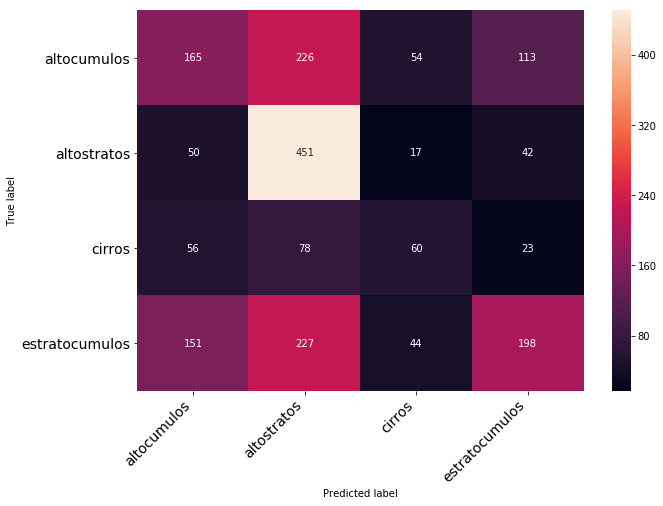

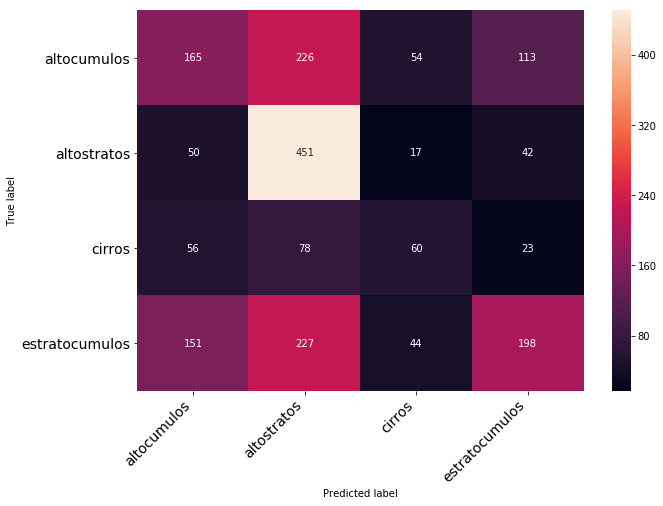

In [164]:
confusion = confusion_matrix(cloud_test_y, output_test)
print_confusion_matrix(confusion, cloud_lookup_table)

In [ ]:
cloud_x[0,0].shape
cloud_test_x.shape

In [ ]:
Variable(torch.Tensor(cloud_test_x[0])).contiguous().cuda().shape

In [ ]:
x = Variable(torch.zeros(1), requires_grad=True)
out = x * 3
out.backward()
x.grad

In [ ]:
net.train()
optimizer.zero_grad()
print(net.forward(cloud_x[0]))